# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 6: RNNs and ELMo


**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<hr style="height:2pt">

### INSTRUCTIONS

- This is an _individual_ homework - No collaboration is permitted

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "Training and validation MSE at varying degree polynomial regression models" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

## **HOMEWORK QUIZ**

**For each part of the homework, there is an associated quiz on [edStem](https://edstem.org/us/courses/17022/lessons/29622/slides/187814). You are required to attempt that after completing each section of this homework. Please note that the quiz is one attempt only.**

## **Setup Notebook**

**Imports**

In [2]:
import time
import requests
import re
import os
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential,model_from_json

from gensim import models
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)
plt.style.use("ggplot")

**Verify Setup**

In [3]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True


2022-04-24 13:03:16.424332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:03:17.315900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:03:17.316652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:03:17.319291: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



    
## **PART 1 [35 points]: Named Entity Recognition**
<br />    
Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.
    
    
In the first part of the homework, you are expected to build a model that will tag words into predefined categories.  
    
    
The dataset consists of sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity



### **PART 1: Questions**

### **1.1 [14 points] PREPROCESS THE DATASET**
<br />
    
**1.1.1** - Read in the dataset `named_entity.csv` into a pandas dataframe using the provided code below.
<br /><br />
    
**1.1.2** - Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**.
<br />

**Note:** Do not modify word capitalization, nor remove any numerical or special characters.
<br />
    
**1.1.3** - Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**.
<br /><br />
    
**1.1.4** - Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
<br />
    
**1.1.5** - Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**
<br /><br />
    
**1.1.6** - It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary that performs inverse mapping.
<br /><br />
    
**1.1.7** - Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sentence encoded as a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
<br /><br />
    
**1.1.8** - Apply the keras ```pad_sequences``` function to standardize the length of predictors by padding with the "ENDPAD" token. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:
<br />
    
`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
<br /><br />
    
**1.1.9** - Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.
<br /><br />
    
**1.1.10** - Prepare targets matrix ```Y```, as a list of lists, where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
<br /><br />
    
**1.1.11** - Apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences' tags and length equal to ```max_length``` previously computed. 
<br /><br />
    
**1.1.12** - Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.
<br /><br />
    
**1.1.13** - Split the dataset into train and test sets with a 10% test split using 109 for your random state. Assign your training data to the variables X_tr and y_tr and your test data to the variables X_te and y_te
<br /><br />
    
### **1.2 [10 points] MODELLING THE DATA**
      
Now that you've prepared the train and test sets, you'll build the following model:
    
> - Bidirectional Gated Recurrent Neural Network with input/ouput dimensionalities as 
    - input: [# of sentences, max_len]\
    - output: [# of sentences, max_len, n_tags]\
    
Follow the information in each model's section to set up the architecture of each model.

A further plot_training_history helper function is given in case you need to check the training history.
<br /><br />  
    
    
**1.2.1** - BIDIRECTIONAL GATED RECURRENT NEURAL NETWORK
<br />
    
> Explain:
>- how does a Bidirectional GRU differs from a GRU _without_ this bidirectional wrapper
>- how does a GRU differ from a simple RNN?
>- how does a GRU differ from an LSTMs.
<br />
    
**1.2.2** - Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional layer. Use the provided code to plot the training history.
<br />
    
**1.2.3** - Visualize outputs from bidirectional GRU layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.
<br /><br />


    
### **1.3 [6 points] MODEL ANALYSIS**
<br />
    
**1.3.1** - Apply the model to the test dataset. Compute an F1 score for each ```Tag``` and store it. 
<br />
    
**1.3.2** - Plot the F1 score per Tag for the defined model using barplots.
<br />
    
**1.3.3** - Briefly discuss the performance of the model
    
<br />


    
### **1.4 [5 points] HOMEWORK QUIZ**
<br />
After attempting this part of the homework, answer the questions on <a href=https://edstem.org/us/courses/17022/lessons/29622/slides/187814>edStem</a>. All the questions depend on this part of the homework and you will not be able to answer them without attempting this part.
  
<br /><br />
    
    

## **PART 1: Solutions**


    



### **1.1 [14 points] PREPROCESS THE DATASET**
<br />
    
**1.1.1** - Read in the dataset `named_entity.csv` into a pandas dataframe using the provided code below.
<br /><br />



In [22]:
# Code to read the data
file_path = "https://storage.googleapis.com/cs109b/nlp/ner_dataset.csv"
data = pd.read_csv(file_path,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
**1.1.2** - Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**.
<br />
    
**Note:** Do not modify word capitalization, nor remove any numerical or special characters.
</div>

In [5]:
# Your code here
# Count number of words
words = np.sort(data['Word'].unique()).tolist()
words.append('ENDPAD')
words

n_words = len(words)

print('Length of words "n_words" = ',n_words)

Length of words "n_words" =  35179


In [6]:
# Run this cell to show your results for n_words
print(n_words)

35179


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">


**1.1.3** - Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**.
<br />

</div>

In [7]:
# Your code here
# Count number of tags
tags =  np.sort(data['Tag'].unique()).tolist()
tags.append('PAD')

n_tags = len(tags)

In [8]:
# Run this cell to show your results for n_tags
print(n_tags)

18


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.4** - Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
<br />
    
</div>

In [9]:
# Your code here
# Get maximum sentence length as padding size
dict_sentences = {}
# dict_sentences_lst = {}
for index, row in data.iterrows():
    w = row['Word'] 
    t = row['Tag']
    s = row['Sentence #']
    if dict_sentences.get(s):
        lst = dict_sentences[s]
        lst.append((w, t))
#         lst_only_words.append(w)
    else:
        lst = []
#         lst_only_words =[]
        lst.append((w, t))
#         lst_only_words.append(w)
        dict_sentences[s] = lst
#         dict_sentences_lst[s] = lst_only_words
        
dict_sentences        
    

{'Sentence: 1': [('Thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('London', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('Iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('British', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')],
 'Sentence: 2': [('Families', 'O'),
  ('of', 'O'),
  ('soldiers', 'O'),
  ('killed', 'O'),
  ('in', 'O'),
  ('the', 'O'),
  ('conflict', 'O'),
  ('joined', 'O'),
  ('the', 'O'),
  ('protesters', 'O'),
  ('who', 'O'),
  ('carried', 'O'),
  ('banners', 'O'),
  ('with', 'O'),
  ('such', 'O'),
  ('slogans', 'O'),
  ('as', 'O'),
  ('"', 'O'),
  ('Bush', 'B-per'),
  ('Number', 'O'),
  ('One', 'O'),
  ('Terrorist', 'O'),
  ('"', 'O'),
  ('and', 'O'),
  ('"', 'O'),
  ('Stop', 'O'),
  ('the', 'O'),
  ('Bombings', 'O'),
  ('.', 'O'),
  ('"', 

In [10]:
# data["tuple"] = data[["Word","Tag"]].apply(tuple, axis=1)
# data.groupby('Sentence #')['tuple'].apply(list).reset_index(name='list_tuples')

In [11]:
# dict_sentences_lst

In [12]:
list_of_sentences = list(dict_sentences.values())

list_of_sentences[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.5** - Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**
<br />   
    
</div>

In [13]:
# Your code here
# Get the number of words in the longest sentence

max_len = max(len(item) for item in list_of_sentences)


In [14]:
# Run this cell to show your results for max_len
print(max_len)

104


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.6** - It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary that performs inverse mapping.
<br />  
    
</div>

In [15]:
# Your code here
# Create dictionary to map words to integers

word2idx = {wrd:i for i, wrd in enumerate(words)}

idx2word = {i:wrd for i, wrd in enumerate(words)}

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.7** - Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sentence encoded as a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
<br />
    
</div>

In [16]:
# Your code here
# Prepare predictors list of lists

X = [[word2idx[tup[0]] for tup in v ]for (k,v) in dict_sentences.items()]

X


[[15077,
  27700,
  20969,
  24218,
  26434,
  33389,
  9684,
  33464,
  29396,
  33246,
  34660,
  24853,
  8204,
  17364,
  20924,
  33246,
  34973,
  27700,
  4010,
  33786,
  23512,
  33242,
  20368,
  24],
 [6283,
  27700,
  31967,
  25619,
  24853,
  33246,
  19981,
  25517,
  33246,
  29399,
  34878,
  19044,
  18095,
  34971,
  32712,
  31830,
  17742,
  1,
  4114,
  11464,
  11631,
  14985,
  1,
  17364,
  1,
  14484,
  33246,
  3881,
  24,
  1],
 [15049,
  26434,
  23512,
  33246,
  7826,
  27700,
  11935,
  33464,
  16574,
  29676,
  24853,
  7911,
  11931,
  24],
 [12251,
  29525,
  33246,
  27595,
  27700,
  26435,
  17837,
  214,
  34863,
  27927,
  19427,
  25458,
  34705,
  101,
  24],
 [15029,
  29396,
  19694,
  27768,
  33246,
  22420,
  27700,
  33246,
  17402,
  19952,
  27700,
  4009,
  17,
  30887,
  9354,
  11953,
  24853,
  33246,
  32043,
  5995,
  31157,
  30482,
  27700,
  4004,
  24],
 [15029,
  28268,
  25445,
  21560,
  28023,
  4009,
  17,
  28250,
  248

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.8** - Apply the keras ```pad_sequences``` function to standardize the length of predictors by padding with the "ENDPAD" token. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:
<br />
    
`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
<br />

</div>

In [17]:
# Your code here
# Apply the keras pad_sequences function
X = pad_sequences(X, maxlen=max_len, padding='post', value=word2idx['ENDPAD']) 
X[0]

array([15077, 27700, 20969, 24218, 26434, 33389,  9684, 33464, 29396,
       33246, 34660, 24853,  8204, 17364, 20924, 33246, 34973, 27700,
        4010, 33786, 23512, 33242, 20368,    24, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [18]:
# Run this cell to show your results #
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

Sentence 1: [ 6283 27700 31967 25619 24853 33246 19981 25517 33246 29399 34878 19044
 18095 34971 32712 31830 17742     1  4114 11464 11631 14985     1 17364
     1 14484 33246  3881    24     1 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.9** - Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.
<br />
    
</div>

In [19]:
# Your code here
# Create dictionary to map tags to integers
tag2idx = {tag:i for i, tag in enumerate(tags)}

idx2tag = {i:tag for i, tag in enumerate(tags)}


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.10** - Prepare targets matrix ```Y```, as a list of lists, where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
<br />
    
</div>

In [20]:
# Your code here
# Prepare targets list of lists

Y = [[tag2idx[tup[1]] for tup in v ]for (k,v) in dict_sentences.items()]

Y

[[16,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  16,
  16],
 [16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  6,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16],
 [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 2, 10, 16],
 [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
 [16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  5,
  13,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  2,
  16],
 [16,
  16,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  16,
  2,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  16,
  16],
 [16,
  2,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  2,
  16,
  2,
  16,
  16,
  2,
  16],
 [16,
  5,
  13,
  13,
  13,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  2,
  7,
  16,
  16,
  16,
  16,
  16,
  3,
  16,
  16,
  16,
  16,

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.11** - Apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences' tags and length equal to ```max_length``` previously computed. 
<br />
    
</div>

In [21]:
# Your code here
# Apply the kera pas_sequences function
Y = pad_sequences(Y, maxlen=max_len, padding='post', value=tag2idx['PAD']) 


In [22]:
# Run this cell to show your results #
print("Sentence 1 Tags: {}\n".format(Y[1]))
print(Y.shape)

Sentence 1 Tags: [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16  6 16 16 16 16 16
 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17]

(47959, 104)


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

**1.1.12** - Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.
<br />
    
</div>

In [23]:
# Your code here
# Onehot encode target variable

y = to_categorical(Y, n_tags)

In [24]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
**1.1.13** - Split the dataset into train and test sets with a 10% test split using 109 for your random state. Assign your training data to the variables X_tr and y_tr and your test data to the variables X_te and y_te
<br />
    
</div>

In [25]:
# Your code here
# Split train/test datasets
X_tr,  X_te, y_tr , y_te = train_test_split(X, y, test_size=0.1, random_state=109)

print(X_tr.shape)
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(43163, 104)
(4796, 104)
(43163, 104, 18)
(4796, 104, 18)


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

### **1.2 [10 points] MODELLING THE DATA**
      
Now that you've prepared the train and test sets, you'll build the following model:

> - An Embedding layer with input dimension as the number of words in the vocab and output dimension as 50
> - Add a dropout layer with a dropout rate of `0.1`
> - Bidirectional Gated Recurrent Neural Network with input/ouput dimensionalities as 
    * input: [# of sentences, max_len]
    * output: [# of sentences, max_len, n_tags]
    * Apply the wrapper "TimeDistributed" to the layer after the Bidirectional GRU so that it applies a layer to all time steps of the input sequence.
> - The final Dense layer (i.e., output layer) will have `units=n_tags` and appropriate activation

A further plot_training_history helper function is given in case you need to check the training history.
<br /><br />  
    
**1.2.1** - BIDIRECTIONAL GATED RECURRENT NEURAL NETWORK
<br />
    
> Explain:
>- how does a Bidirectional GRU differs from a GRU _without_ this bidirectional wrapper
>- how does a GRU differ from a simple RNN?
>- how does a GRU differ from an LSTMs.
<br />
    
    
</div>


**Your answer here**

**Use these hyperparameters for the NN models**

In [51]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1



In [52]:
# # Create a function for all model options
# def build_model(num_classes,vocab_size,embedding_dim,rnn_layers,bidir):
#     # Model input
#     model_input = tf.keras.Input(shape=(None,), name='sentence_input')

#     # Embedding
#     hidden = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
#                         name='word_embedding', mask_zero=True)(model_input)
#     hidden = tf.keras.layers.Dropout(drop_rate)(hidden)
#     # Create RNNs
#     hidden_forward = []
#     hidden_backward = []
#     for k in range(rnn_layers):
#         # Forward RNN layer
#         hidden = tf.keras.layers.GRU(units=embedding_dim, return_sequences=True)(hidden)
        
#         hidden_forward.append(hidden)

#         # Backward RNN layer
#         if bidir:
#             hidden_b = tf.keras.layers.GRU(units=embedding_dim, return_sequences=True, go_backwards=True)(hidden)
#             hidden_backward.append(hidden_b)
  
#     if bidir:
#         hidden = tf.keras.layers.concatenate(hidden_forward+hidden_backward)
#     else:
#         if rnn_layers==1:
#             hidden = hidden_forward[0]
#         else:
#             hidden = tf.keras.layers.concatenate(hidden_forward)

#     # Output Layer
#     output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

#     # Create model
#     model = tf.keras.Model(inputs=model_input, outputs=output, name='_'.join([str(embedding_dim), str(rnn_layers),str(bidir)]))
#     return model

In [67]:
# Create a function for all model options
def build_model(num_classes,vocab_size,embedding_dim,rnn_layers,bidir):
    # Model input
    model_input = tf.keras.Input(shape=(None,), name='sentence_input')

    # Embedding
    hidden = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                        name='word_embedding', mask_zero=True)(model_input)
    hidden = tf.keras.layers.Dropout(drop_rate)(hidden)
    # Create GRU
    hidden_forward = []
    hidden_backward = []
    hidden = tf.keras.layers.GRU(units=embedding_dim, return_sequences=True)(hidden)
    hidden_forward.append(hidden)
    if bidir:
        hidden_b = tf.keras.layers.GRU(units=embedding_dim, return_sequences=True, go_backwards=True)(hidden)
        hidden_backward.append(hidden_b)
    if bidir:
        hidden = tf.keras.layers.concatenate(hidden_forward+hidden_backward)
    # Output Layer
    output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

    # Create model
    model = tf.keras.Model(inputs=model_input, outputs=output, name='_'.join([str(embedding_dim), str(rnn_layers),str(bidir)]))
    return model

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

> **1.2.2** - Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional layer. Use the provided code to plot the training history.
<br />

</div>

In [68]:
model = build_model(num_classes,vocabulary_size, dim_embed, 1, True)

# Print the model architecture
print(model.name)
print(model.summary())

50_1_True
Model: "50_1_True"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence_input (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, None, 50)     1758950     ['sentence_input[0][0]']         
                                                                                                  
 dropout_2 (Dropout)            (None, None, 50)     0           ['word_embedding[0][0]']         
                                                                                                  
 gru_2 (GRU)                    (None, None, 50)     15300       ['dropout_2[0][0]']              
                                                                                

In [69]:
# Your code here
# Define model

vocabulary_size = n_words #35179
num_classes = n_tags#18

K.clear_session()

# Build the model
model = build_model(num_classes,vocabulary_size, dim_embed, 1, True)

# Print the model architecture
print(model.name)
# print(model.summary())


# Compile
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Train model
start_time = time.time()
training_results = model.fit(
              X_tr,y_tr,
              validation_split= validation_split,
              batch_size=batch_size,
              epochs=epochs, 
              verbose=1)


50_1_True
Epoch 1/10
1214/1214 [==============================] - 38s 26ms/step - loss: 0.0914 - accuracy: 0.9785 - val_loss: 0.0350 - val_accuracy: 0.9899
Epoch 2/10
1214/1214 [==============================] - 29s 24ms/step - loss: 0.0296 - accuracy: 0.9913 - val_loss: 0.0304 - val_accuracy: 0.9910
Epoch 3/10
1214/1214 [==============================] - 28s 23ms/step - loss: 0.0262 - accuracy: 0.9923 - val_loss: 0.0295 - val_accuracy: 0.9913
Epoch 4/10
1214/1214 [==============================] - 29s 24ms/step - loss: 0.0244 - accuracy: 0.9928 - val_loss: 0.0287 - val_accuracy: 0.9916
Epoch 5/10
1214/1214 [==============================] - 29s 24ms/step - loss: 0.0233 - accuracy: 0.9932 - val_loss: 0.0282 - val_accuracy: 0.9917
Epoch 6/10
1214/1214 [==============================] - 29s 24ms/step - loss: 0.0223 - accuracy: 0.9934 - val_loss: 0.0277 - val_accuracy: 0.9919
Epoch 7/10
1214/1214 [==============================] - 29s 24ms/step - loss: 0.0216 - accuracy: 0.9937 - val_loss

In [70]:
# Run this cell to show your results #
print(model.summary())

Model: "50_1_True"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence_input (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, None, 50)     1758950     ['sentence_input[0][0]']         
                                                                                                  
 dropout (Dropout)              (None, None, 50)     0           ['word_embedding[0][0]']         
                                                                                                  
 gru (GRU)                      (None, None, 50)     15300       ['dropout[0][0]']                
                                                                                          

In [71]:
# Helper code to plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

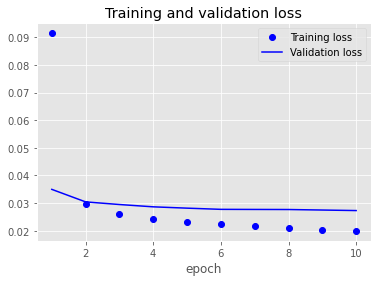

In [74]:
# Run this cell to show your results #
plot_training_history(training_results)

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
> **1.2.3** - Visualize outputs from bidirectional GRU layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.
<br />

</div>

**Helper function to visualize the outputs**


In [ ]:
def get_hidden_output_PCA(model, X_te, y_te, layer_index, out_dimension):
    """Generate hidden layer output PCA transformation
    
    Captures the output of a specific layer in a Keras model and then 
    returns a transformed PCA object. Also, prints the variance explained 
    by the first two principal components.  
    
    :param model: Keras trained model object
    :param X_te: np.array, X test data
    :param y_te: np.array, y test data
    :param layer_index: int, index of model layer for which to inspect output
    :param out_dimension: int, output embedding dimension of chosen layer
    :return: Fitted and transformed sklearn PCA model object
    """
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [ ]:
def visualize_B_I(pca_result, y_te):
    """Visualize the first 2 PCA dimensions, labeled by tag
    
    Constructs two subplots showing the first two principal components of
    the `B-tags` and `I-tags` in the transformed PCA object provided
    
    :param pca_result: sklearn PCA object
    :param y_te: np.array, y test data
s    """
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0],
                          pca_result[indices, 1],
                          label=idx2tag[cat],s=2,
                          color=color[cat-8*i],
                          alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

In [ ]:
# Your code here
# Visualization of hidden features


**Your answer here**

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">


    
### **1.3 [6 points] MODEL ANALYSIS**
<br />
    
> **1.3.1** - Apply the model to the test dataset. Compute an F1 score for each ```Tag``` and store it. 
<br />
</div>

In [112]:
# Your code here
# Apply the model to the test dataset

y_pred = model.predict(X_te)
# y_true = np.ndarray.flatten(np.argmax(y_te, axis=1))
# y_pred = np.ndarray.flatten(np.argmax(y_pred,axis=1))

pred_n=np.array([i.argmax(axis=1) for i in pred])
y_te_n=np.array([i.argmax(axis=1) for i in y_te])

print(y_true.shape)
print(y_pred.shape)

print(f1_score(y_true, y_pred, average=None))

print(confusion_matrix(y_true, y_pred, average=None))

(86328,)
(86328,)
[0.21598025 0.17997127 0.19265708 0.18628498 0.19547589 0.20004274
 0.18460211 0.1855916  0.18318028 0.17866732 0.1832731  0.17750141
 0.16870824 0.17291415 0.17908453 0.15806806 0.17472816 0.17088879
 0.15672616 0.16101695 0.15578716 0.17       0.13959234 0.16289593
 0.14821124 0.13683224 0.12107623 0.11682893 0.13751868 0.11262136
 0.12356979 0.11886305 0.15047022 0.13389121 0.12871287 0.13333333
 0.0625     0.15686275 0.17582418 0.03508772 0.05       0.10810811
 0.         0.         0.         0.18181818 0.25       0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.10526316 0.         0.         0.
 0.07142857 0.         0.         0.04545455 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.     

In [115]:
y_pred = model.predict(X_te)
y_pred.shape

(4796, 104, 18)

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">


    
> **1.3.2** - Plot the F1 score per Tag for the defined model using barplots.

</div>

In [ ]:
# Your code here
# Plot the F1-score of the model per tag


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
> **1.3.3** - Briefly discuss the performance of the model
<br />


</div>

**Your answer here**



### **1.4 [5 points] HOMEWORK QUIZ**

After attempting this part of the homework, answer the questions on <a href=https://edstem.org/us/courses/17022/lessons/29622/slides/187814>edStem</a>. All the questions depend on this part of the homework and you will not be able to answer them without attempting this part.
<br />


#### Answer the questions on EdStem

___
___



    
## **PART 2 [65 points]: IMDB Sentiment Analysis using ELMo**
<br />    
Sentiment analysis, also known as opinion mining or emotion AI, is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.
    
For this part of the homework, we will be using the IMDB dataset, which is publicly available [here](http://ai.stanford.edu/~amaas/data/sentiment/).    

This represents a "many-to-one" problem, with the output classified as a `positive` or `negative` sentiment, depending on the words used in the review.
    
    
In the first part of this section, you are expected to build a language model to train a basic ELMo.
    
Although the original ELMo implementation uses *Character Embeddings*, for the sake of this homework, we will use word embeddings instead.
    
Read more about the ELMo paper [here](https://arxiv.org/pdf/1802.05365.pdf).

In the second part of this subsection, you will use the generated ELMo embeddings in a deep learning model to perform sentiment analysis using the IMDB dataset. 
    
You will compare its performance, with a baseline model without any trained embeddings, and another model which directly uses the `word2vec` embeddings.

<br />

### **PART 2: Questions**
<br />

### **2.1 [20 points] PREPROCESS THE DATASET**
<br />
    
**2.1.1** - Load the dataset

For simplicity, we will use the training split of the IMDB dataset.
- Limit to the most frequent 5000 words.
- Do not skip any frequently occuring words.
- Limit the largest review to a maximum of 200 words only. 
    
    
**NOTE**: You can use the `imdb.get_word_index()` to get the mapping between tokens and words. This will load a dictionary with the mappings, which has to be corrected. Helper code provided below to fix the dictionary.
    
Read more about `tf.keras.datasets.imdb` [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?version=nightly).    
    
To each review, you must add an end of sentence token \<\/s\> .

Eg. Review: "\<s\> This movie is so bad, I had to leave early"
    
Modified review: "\<s\> This movie is so bad, I had to leave early \<\/s\>"
    
**2.1.2** - Load the `word2vec` embeddings
    
You will use the pre-trained `word2vec` embeddings for this section of the homework. This file is provided to you and can be accessed like a dictionary.
    
Add the \<s\> and\</s\> tokens to the `word2vec` embeddings as random vectors.    
    
**NOTE**: Not all the words in the reviews are present in the embeddings file provided to you. Hence, if it is not present, you must OMIT that word from the sentence.
   
E.g. If `and` token is not present in the embeddings:
   
```
OLD SENTENCE: <s>The movie was good and I really liked it </s>
    
NEW SENTENCE: <s> The movie was good I really liked it </s>
    
``` 
    
<br /><br />
    
**2.1.3** Create `tf.Dataset` for model training:
    
- Create another object called `embeddings_list`, which maps the tokens to their `word2vec` representations.    

- Split the data (`tokens_list`, `embeddings_list`, `class_list`) into 80% training and 20% validation. We will use the `class_list` (which is the sentiment associated with each movie review) only in Part 2.3 for sentiment analysis.
    
- Build a `tf.Dataset` for training, and another one for validation.
    
Define a function to create the dataset. It should have as input the sentences embeddings and the target indices.

Instead of preprocessing the entire dataset, we can preprocess a batch. It is faster and consumes less resources, which is optimal for training.

`dataset.map` enable us to apply a function to each element of the batch individually. The parameter `num_parallel_calls` allow us to control how many threads we will use to feed the network. This function has to output the tensors that will be used in the training in the correct format.

It should output a tuple of two elements.

    1. Source sentences for both LSTMs and the length of the sentnce: (`inputs_f`, `inputs_b`, `inputs_N` )
    2. Target sentences for both LSTMs: (`target_f`,`target_b`)
    
For the same sentence, we will need a target for the forward LSTM and one for the backward LSTM.   
Hence, make sure to create *two* targets in the dataset, `target_f` and `target_b`.    
    

Both `inputs_f` and `inputs_b` will be a `Tensor` with dimensions: `(batch_size,length_of_sentence-1,embedding_dimension)`.
    
Each of the targets,  will be a `Tensor` with dimensions: `(batch_size, length_of_sentence)`.   
    
<br /><br />
 
    
### **2.2 [20 points] Define and train the model**
    
We define an *ELMo-like* language model using bi-directional LSTMs and residual connections  **without** the character CNN to simplify the analysis. 
    
We will use the `word2vec` embeddings instead of the character representations of the CNN.
    
For simplicity, we train our *ELMo-like* language model on the IMDB dataset itself. But generally, language models are trained on much larger corpuses.    
    
**2.2.1** Building the language model
    
The model should have as an input *padded_sentences* followed by a `tf.keras.layers.Masking()` layer.   
    
After this, you can use the helper code given below to split the input data to feed the *forward* and *backward* LSTMs.
    
Refer to the image from lecture slides on ELMo.
    
![](https://storage.googleapis.com/public_colab_images/nlp/elmo/forward_backward.png) 
    

Remember to use the **same** *softmax* layer ` on both the forward and the backward LSTMs. This will give you an `output_f` and `output_b` which you will evaluate with your two targets.
    
Refer to the lecture slides for more clarity.       

![](https://storage.googleapis.com/public_colab_images/nlp/elmo/loss.png)

Use an appropriate loss function, and optimizer and train the network sufficiently.    

Finally, plot the training history of the train and validation loss.
    
**2.2.2** Extracting ELMo embeddings
    
Use the Functional API to build another model called `Toy_ELMo` to obtain the embeddings of the model. 

    

The embeddings obtained should be: 
    
1. The `word2vec` embeddings 
        
    This is just the output after the masked layer in the language model defined above.    
    
2. The first bidirectional-LSTM layer embeddings 

    This will be the concatenation of the first LSTM layers of the language model (`h1_f + h1_b`).
    
3. The second bidirectional-LSTM layer embeddings

    This will be the concatenation of the second LSTM layer of the language model (`h2_f + h2_f`).    
    
You can use the helper code provided in this sub-section to obtain the concatenation of the different embeddings.             
    
<br /><br />
    
### **2.3 [20 points] Transfer Learning**
<br />
    
Once you've sufficiently trained your ELMo embeddings, we can use it for a down-stream task such as sentiment analysis.
    
You have already done sentiment analysis using `tf.keras.layers.Embedding()`. You will now aim to beat that baseline using your ELMo embeddings.    
    
**2.3.1** - Baseline model:
    
For the baseline model, you will use:
    
> - `tf.keras.Layers.Embedding()` layer
> -  2 layers of `LSTM` with `hidden_size=300` 
    
       
Train it for sufficient epochs using an appropriate optimizer and learning rate.

Finally, plot the training history of the train and validation loss.
    
**2.3.2** - Directly using pre-trained `word2vec`:
    
For this section, use the pre-trained `word2vec` embeddings directly into your model. 
    
You will build a `tf.Dataset` similar to the one created in Section 2.1 but instead of having a target as a series, the target should only be a class (positive or negative sentiment).    
    
Train, and compare its performance with the baseline model defined above **using the same architecture** as above.
    
**2.3.3** - Using ELMo embeddings:
    
    
> - Define the same model as above but use the `Toy_ELMo` after the input layer. 
    
**NOTE**: Set `Toy_ELMo.trainable` to `False` to avoid retraining the model. 
        
> - Create the **sauce** layer to combine the three embeddings from your `Toy_ELMo`. You should have **three** trainable parameters in this layer

<img src="https://storage.googleapis.com/public_colab_images/nlp/elmo/sauce.png" alt="drawing" style="width:300px;"/>    
    
Since we are not using any other embeddings, we will set the value of $\gamma$ to 1.     
> - Train the modified model sufficiently, and compare it to the previously trained models.

<br /><br />
    
### **2.4 [5 points] HOMEWORK QUIZ**
<br />
After attempting this part of the homework, answer the questions on edStem. All the questions depend on this part of the homework and you will not be able to answer them without attempting this part.
  
<br /><br />


## **PART 2: Solutions**    





### **2.1 [20 points] PREPROCESS THE DATASET**
<br />
    
**2.1.1** - Load the dataset

For simplicity, we will use the training split of the IMDB dataset.
- Limit to the most frequent 5000 words.
- Do not skip any frequently occuring words.
- Limit the largest review to a maximum of 200 words only. 
    
    
**NOTE**: You can use the `imdb.get_word_index()` to get the mapping between tokens and words. This will load a dictionary with the mappings, which has to be corrected. Helper code provided below to fix the dictionary.
    
Read more about `tf.keras.datasets.imdb` [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?version=nightly).    
    
To each review, you must add an end of sentence token \<\/s\> .

Eg. Review: "\<s\> This movie is so bad, I had to leave early"
    
Modified review: "\<s\> This movie is so bad, I had to leave early \<\/s\>"


<br /><br />



In [4]:
# Reference to imdb dataset
imdb = tf.keras.datasets.imdb

In [5]:
### Helper code to fix the mapping of the imdb word index
index = imdb.get_word_index()
# we need to add 3 from the indices because 0 is 'padding', 1 is 'start of sequence' and 2 is 'unknown'
inv_index = { j+3:i for i,j in index.items()}

# Tags for start and end of sentence
# inv_index[0] = 'padding' 
# inv_index[1] = '<s>' 
# inv_index[2] = 'unknown' 
# inv_index[3] = '</s>'

inv_index[0] = ""
inv_index[1] = "<s>"
inv_index[2] = "UNK"
inv_index[3] = '</s>'

index = { j:i for i,j in inv_index.items()}

In [9]:
# inv_index[3]
# index['</s>']

3

In [6]:
# Your code here
n_words = 5000
data_train, data_validation = tf.keras.datasets.imdb.load_data(num_words=n_words, maxlen=100 )
# data_train[0][0]

In [7]:
print("data_train input shape:",data_train[0].shape)
print("data_train output shape:",data_train[1].shape)
print("data_validation input shape:",data_validation[0].shape)
print("data_validation output shape:",data_validation[1].shape)

# View a training samples
for i in range(5):
    print("Length:",len(data_train[0][i]))
    print('Input = ',data_train[0][i])
    print('Output =',data_train[1][i])

data_train input shape: (2773,)
data_train output shape: (2773,)
data_validation input shape: (2963,)
data_validation output shape: (2963,)
Length: 43
Input =  [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
Output = 0
Length: 99
Input =  [1, 54, 13, 1610, 14, 20, 13, 69, 55, 364, 1398, 21, 54, 13, 219, 12, 13, 1706, 15, 4, 20, 16, 329, 6, 176, 329, 74, 51, 13, 873, 4, 156, 71, 78, 4, 2, 322, 16, 31, 7, 4, 249, 4, 65, 16, 38, 379, 12, 100, 157, 18, 6, 910, 20, 549, 18, 4, 1496, 21, 14, 31, 9, 24, 6, 212, 12, 9, 6, 1322, 991, 7, 3002, 4, 425, 9, 73, 2218, 549, 18, 31, 155, 36, 100, 763, 379, 20, 103, 351, 2, 13, 202, 12, 2241, 5, 6, 320, 46, 7, 457]
Output = 0
Length: 93
Input =  [1, 4, 204, 2, 20, 16, 93, 11, 2, 19, 2, 4390, 6, 55, 52, 22, 849, 4227, 119, 7, 2, 961, 178, 6, 1018, 221, 20, 1184, 2, 2, 29, 7, 265, 16, 530, 17, 29, 220, 210, 468, 8, 30,

In [8]:
X  = [i for i in data_train[0]]
y  = [i for i in data_train[1]]

validation_x  = [i for i in data_validation[0]]
validation_y  = [i for i in data_validation[1]]

# X.append(3)
# validation_x.append(3)
for i in X:
    i.append(3)

for i in validation_x:
    i.append(3)

# X[1]
# validation_x[1]

In [9]:
# Display actual text
review = [inv_index[token] for token in X[0]]
print("review:"," ".join(review))

review: <s> begins better than it ends funny that the russian UNK crew UNK all other actors it's like those scenes where documentary shots br br spoiler part the message UNK was contrary to the whole story it just does not UNK br br </s>


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
**2.1.2** - Load the `word2vec` embeddings
    
You will use the pre-trained `word2vec` embeddings for this section of the homework. This file can be downloaded from [here](https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz) and can be accessed like a dictionary.
    
Add the \<s\> and\</s\> tokens to the `word2vec` embeddings as random vectors.    
    
**NOTE**: Not all the words in the reviews are present in the embeddings file. Hence, if it is not present, you must OMIT that word from the sentence.
   
E.g. If `and` token is not present in the embeddings:
   
```
OLD SENTENCE: <s>The movie was good and I really liked it </s>
    
NEW SENTENCE: <s> The movie was good I really liked it </s>
    
``` 
        
    
<br />    


</div>

In [ ]:
# Download the word2vec weights
# !wget https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz

In [10]:

# Your code here

start_time = time.time()
# Dowload the news dataset
word2vec_path = tf.keras.utils.get_file(
    origin="https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz",
    extract=False)
print("word2vec_path:",word2vec_path)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

word2vec_path: /home/u_61393463/.keras/datasets/GoogleNews-vectors-negative300.bin.gz
Download execution time (mins) 0.00018125375111897787


In [11]:
# Load word2vec
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

print("Number of word vectors:",word2vec.vectors.shape)

Number of word vectors: (3000000, 300)


In [12]:
# Add the <s> and</s> tokens to the word2vec embeddings as random vectors.

random_vec1 = np.random.random(300)
random_vec2 = np.random.random(300)

# print('random_vec1', random_vec1)
# print('random_vec2', random_vec2)
# word2vec.vectors_norm = None
word2vec['<s>']  = random_vec1
word2vec['</s>'] = random_vec2



In [13]:
# View some word embeddings
sample_embeddings_words = ["news", "data", "hurricane", "political",'<s>']
for word in sample_embeddings_words:
    print(word,":",word2vec[word][:5],", Shape:", word2vec[word].shape)

news : [-0.13867188  0.04370117 -0.13085938 -0.16796875 -0.06054688] , Shape: (300,)
data : [-0.17285156 -0.14257812  0.04370117 -0.03344727 -0.07861328] , Shape: (300,)
hurricane : [ 0.14453125 -0.11083984 -0.3671875   0.10449219  0.06396484] , Shape: (300,)
political : [-0.02868652  0.02929688 -0.0625      0.35351562 -0.11181641] , Shape: (300,)
<s> : [0.6964692  0.28613934 0.22685145 0.5513148  0.71946895] , Shape: (300,)


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
        
    
**2.1.3** Create `tf.Dataset` for model training:
    
- Create another object called `embeddings_list`, which maps the tokens to their `word2vec` representations.    

- Split the data (`tokens_list`, `embeddings_list`, `class_list`) into 80% training and 20% validation. We will use the `class_list` (which is the sentiment associated with each movie review) only in Part 2.3 for sentiment analysis.
    
- Build a `tf.Dataset` for training, and another one for validation.
    
Define a function to create the dataset. It should have as input the sentences embeddings and the target indices.

Instead of preprocessing the entire dataset, we can preprocess a batch. It is faster and consumes less resources, which is optimal for training.

`dataset.map` enable us to apply a function to each element of the batch individually. The parameter `num_parallel_calls` allow us to control how many threads we will use to feed the network. This function has to output the tensors that will be used in the training in the correct format.

It should output a tuple of two elements.

    1. Source sentences for both LSTMs and the length of the sentnce: (`inputs_f`, `inputs_b`, `inputs_N` )
    2. Target sentences for both LSTMs: (`target_f`,`target_b`)
    
For the same sentence, we will need a target for the forward LSTM and one for the backward LSTM.   
Hence, make sure to create *two* targets in the dataset, `target_f` and `target_b`.    
    

Both `inputs_f` and `inputs_b` will be a `Tensor` with dimensions: `(batch_size,length_of_sentence-1,embedding_dimension)`.
    
Each of the targets,  will be a `Tensor` with dimensions: `(batch_size, length_of_sentence)`.
    
        
<br /><br />

</div>

In [14]:
# Helper code

# Fill the required cells to complete the function
def transform_pad(input_tensor, input_target, input_N):
    # Transform the input for the f and b LSTM
    input_f  = input_tensor[:,:-1,:]
    input_b  = input_tensor[:,1:,:]
    
    # Transform the target for the f and b LSTM
    target_f  = input_target[:,1:]
    target_b  = input_target[:,:-1]
    
    # Pad the inputs
    input_f.to_tensor(default_value=0, shape=[None, None, 300])
    input_b.to_tensor(default_value=0, shape=[None, None, 300])
    
    # Pad the targets
    target_f.to_tensor(default_value=0, shape=[None, None])
    target_b.to_tensor(default_value=0, shape=[None, None])  

    
    return (input_f, input_b, input_N), (target_f, target_b)

def create_dataset(data_in, target_in):
   
    #Get the length of each sentence
    # list containing length of each sentence in the data_in
    N = [len(sent) for sent in data_in]
    tensor_N = tf.constant(N, tf.int32)
    
    # Create ragged tensors 
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    ragged_target = tf.ragged.constant(target_in, tf.int32)

    
    # Build the dataset and the operations
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, ragged_target, tensor_N))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(256)
    
# Transform_pad function is defined above; you can change the num_parallel_calls    
    dataset = dataset.map(transform_pad, num_parallel_calls=1)
    
                          
    dataset = dataset.prefetch(1)
    return dataset

In [15]:
# token_list = X
embeddings_list = [[word2vec[inv_index[word]] for word in sentence if inv_index[word] in word2vec] for sentence in X]
tokens_list = [[i for i in review if inv_index[i] in word2vec] for review in X]

class_list = y

# embeddings_list = [[inv_index[each_token] for each_token in each_sent_token]for each_sent_token in X]

# embeddings_list = [[word2vec[inv_index[word]] for word in sentence if inv_index[word] in word2vec] for sentence in X]
# tokens_list = [[i for i in review if inv_index[i] in word2vec] for review in x_train]

In [16]:
# Split the data (tokens_list, embeddings_list, class_list) into 80% training and 20% validation. 
# We will use the class_list (which is the sentiment associated with each movie review) only in Part 2.3 
# for sentiment analysis.

token_train, token_test,embed_train, embed_test, class_train, class_test = train_test_split(tokens_list,embeddings_list, class_list, train_size=0.8, random_state=109)

print(len(token_train))
print(len(token_test))
print(len(embed_train))
print(len(embed_test))
print(len(class_train))
print(len(class_test))


2218
555
2218
555
2218
555


In [17]:
# Build a tf.Dataset for training, and another one for validation.

train_data = create_dataset(embed_train, token_train) #(input_f, input_b, input_N), (target_f, target_b)
test_data = create_dataset(embed_test, token_test)


In [63]:
# View some data from tf dataset
for input,output in train_data.take(1):
  print(input[0].shape,output[0].shape)
  
  print("Input:",input[0][0])
  print("Output:",output[0][0])
  print("****************")
#   print("Input:",input[1])
#   print("Output:",output[1])

(256, None, None) (256, None)
Input: <tf.RaggedTensor [[0.6964692, 0.28613934, 0.22685145, ..., 0.84605485, 0.12392301,
  0.5964869],
 [0.109375, 0.140625, -0.03173828, ..., 0.007659912, 0.12011719,
  -0.1796875],
 [0.0070495605, -0.07324219, 0.171875, ..., 0.011230469, 0.1640625,
  0.106933594],
 ...,
 [0.0703125, 0.08691406, 0.087890625, ..., -0.047607422, 0.014465332,
  -0.0625],
 [0.071777344, 0.20800781, -0.028442383, ..., -0.16796875, -0.020874023,
  -0.14257812],
 [0.029174805, 0.203125, 0.047607422, ..., -0.13085938, 0.09326172,
  -0.044433594]]>
Output: tf.Tensor(
[  14    9    4    2   15    2  115   16   17   76   17   13  473  119
    2   12  210  468   99    2   18   72  235   18   12   94  816    9
   31   61  514    2  151    2   23    4   85  508 1102   33    2 2036
   99  550 1062  151   45  643 4742   11   94 1674 4952  787   44  532
    2  452   12  495   88 3069    4  360    4  177  471   11   87  354
    3], shape=(71,), dtype=int32)
****************


In [ ]:
# Your code here

# embeddings_list = lists after  applying the word2vec embedding  on X_train 
# tokens_list = X_train , as they are already been tokinzed when we load them from the imdb.load_data
# class_list = y_train

# Correct, you will be converting the tokenized version of your X_train to the embeddings for embeddings_list. 
# tokens_list and class_list should be your X and Y from the earlier parts of problem 2.1.

In [31]:
# embeddings_list =[]
# notfound_wrds_inv_idex =[]
# notfound_wrds_w2v =[]

# for each_sent_token in X:
#     each_sent_emb_vec =[]
#     for each_token in each_sent_token:
#         try:
#             wrd = inv_index[each_token]
#         except KeyError:
#             notfound_wrds_inv_idex.append(wrd)
#         #print(wrd)
#         try:
#             vec = word2vec[wrd]
#         except KeyError:
#             notfound_wrds_w2v.append(wrd)
#         each_sent_emb_vec.append(vec)
#     embeddings_list.append(each_sent_emb_vec)

In [58]:
# data_in = embed_train
# target_in = token_train

# N = [len(sent) for sent in data_in]
# tensor_N = tf.constant(N, tf.int32)
    
#     # Create ragged tensors 
# ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
# ragged_target = tf.ragged.constant(target_in, tf.int32)

    
# #     # Build the dataset and the operations
# dataset = tf.data.Dataset.from_tensor_slices((ragged_input, ragged_target, tensor_N))
# dataset = dataset.shuffle(1000)
# dataset = dataset.batch(256)
    
# # # Transform_pad function is defined above; you can change the num_parallel_calls    
# dataset = dataset.map(transform_pad, num_parallel_calls=1)
    
# dataset = dataset.prefetch(1)

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
    
### **2.2 [20 points] Define and train the model**
    
We define an *ELMo-like* language model using bi-directional LSTMs and residual connections  **without** the character CNN to simplify the analysis. 
    
We will use the `word2vec` embeddings instead of the character representations of the CNN.
    
For simplicity, we train our *ELMo-like* language model on the IMDB dataset itself. But generally, language models are trained on much larger corpuses.    
    
**2.2.1** Building the language model
    
The model should have as an input *padded_sentences* followed by a `tf.keras.layers.Masking()` layer.   
    
After this, you can use the helper code given below to split the input data to feed the *forward* and *backward* LSTMs.
    
Refer to the image from the lecture slides on ELMo.
    
![](https://storage.googleapis.com/public_colab_images/nlp/elmo/forward_backward.png) 
    

Remember to use the **same** *softmax* layer on both the forward and the backward LSTMs. 
    
This will give you an `output_f` and `output_b` which you will evaluate with your two targets.
    
Refer to the lecture slides for more clarity.       

![](https://storage.googleapis.com/public_colab_images/nlp/elmo/loss.png)

Use an appropriate loss function, and optimizer and train the network sufficiently.   
 
<br/>
Finally, plot the training history of the train and validation loss.
</div>    

In [59]:
def build_lstm_residual_connections_model(num_classes,vocab_size,embedding_dim,hidden_size):
    # Model input
    model_input_f = tf.keras.Input(shape=(None,embedding_dim), name='sentence_input_f')   
#     mask_f = tf.keras.layers.Masking()(model_input_f)
    mask_f = tf.keras.layers.Masking(mask_value=0)(model_input_f)

    # Add an LSTM layer with hidden size and return the sequences
    hidden1 = tf.keras.layers.LSTM(name = 'LSTM_FWD1',units=hidden_size, return_sequences=True)(mask_f)
    embedding_projections = tf.keras.layers.Dense(name = 'DENSE_EMBED_PROJ_FWD', units=hidden_size, activation='relu')
    residual1 = hidden1 + embedding_projections(mask_f)

    # Add another LSTM layer with hidden size and return the sequences
    hidden2 = tf.keras.layers.LSTM(name = 'LSTM_FWD2',units=hidden_size, return_sequences=True)(residual1)
    dense_f = tf.keras.layers.Dense(name = 'DENSE_FWD',units=hidden_size, activation='relu')(hidden2)

    #-------backward layer
    
    model_input_b = tf.keras.Input(shape=(None,embedding_dim), name='sentence_input_b')   
#     #masking the incoming embeded input
#     mask_b = tf.keras.layers.Masking()(model_input_b)

    # Add an LSTM layer with hidden size and return the sequences
#     hidden1_b = tf.keras.layers.LSTM(name = 'LSTM_BWD1',units=hidden_size, return_sequences=True)(mask_b)
    hidden1_b = tf.keras.layers.LSTM(name = 'LSTM_BWD1',units=hidden_size, return_sequences=True)(model_input_b)
    # Create residual connection
    #residual1 = hidden1 + embedding # This will not work the dimension of embedding cannot be added to hidden1
    embedding_projections_b = tf.keras.layers.Dense(name = 'DENSE_EMBED_PROJ_BWD',units=hidden_size, activation='relu')
#     residual1_b = hidden1_b + embedding_projections_b(mask_b)
    residual1_b = hidden1_b + embedding_projections_b(hidden1_b)

    # Add another LSTM layer with hidden size and return the sequences
    hidden2_b = tf.keras.layers.LSTM(name = 'LSTM_BWD2',units=hidden_size, return_sequences=True)(residual1_b)
    dense_b = tf.keras.layers.Dense(name = 'DENSE_BWD',units=hidden_size, activation='relu')(hidden2_b)

    # Output Layer
    output = tf.keras.layers.Dense(name='FINAL_DENSE',units=num_classes, activation='softmax')
    
    output_1 = output(dense_f)
    output_2 = output(dense_b)
    
    #third input
    model_input_N = tf.keras.Input(shape=(), name='sentence_input_N') 

    # Create model
    model = tf.keras.Model(inputs=[model_input_f, model_input_b, model_input_N], outputs=[output_1, output_2])
    return model

In [60]:
############################
# Training Params
############################
learning_rate = 1e-2
epochs = 3 # 20
embedding_dim = 300
hidden_size = 300
num_classes=n_words
vocabulary_size=n_words
# Free up memory
tf.keras.backend.clear_session()

# Build the model
model = build_lstm_residual_connections_model(num_classes,vocabulary_size, embedding_dim, hidden_size)

# Print the model architecture
print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentence_input_f (InputLayer)  [(None, None, 300)]  0           []                               
                                                                                                  
 sentence_input_b (InputLayer)  [(None, None, 300)]  0           []                               
                                                                                                  
 masking (Masking)              (None, None, 300)    0           ['sentence_input_f[0][0]']       
                                                                                                  
 LSTM_BWD1 (LSTM)               (None, None, 300)    721200      ['sentence_input_b[0][0]']       
                                                                                              

In [61]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
#         validation_data= validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/3


ValueError: in user code:

    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/envs/tensorflow/lib/python3.10/site-packages/keras/layers/recurrent.py", line 901, in _validate_args_if_ragged
        raise ValueError(f'The mask that was passed in was {mask}, which '

    ValueError: Exception encountered when calling layer "LSTM_FWD1" (type LSTM).
    
    The mask that was passed in was tf.RaggedTensor(values=Tensor("model/masking/RaggedSqueeze/Squeeze:0", shape=(None,), dtype=bool), row_splits=Tensor("model/masking/RaggedSqueeze/RaggedFromNestedRowSplits/RaggedFromRowSplits/control_dependency:0", shape=(None,), dtype=int64)), which cannot be applied to RaggedTensor inputs. Please make sure that there is no mask injected by upstream layers.
    
    Call arguments received:
      • inputs=tf.RaggedTensor(values=tf.RaggedTensor(values=Tensor("model/masking/Mul_2:0", shape=(None,), dtype=float32), row_splits=Tensor("model/masking/RaggedTile/concat_2:0", shape=(None,), dtype=int64)), row_splits=Tensor("model/masking/RaggedTile/concat_1:0", shape=(None,), dtype=int64))
      • mask=tf.RaggedTensor(values=Tensor("model/masking/RaggedSqueeze/Squeeze:0", shape=(None,), dtype=bool), row_splits=Tensor("model/masking/RaggedSqueeze/RaggedFromNestedRowSplits/RaggedFromRowSplits/control_dependency:0", shape=(None,), dtype=int64))
      • training=True
      • initial_state=None


In [ ]:
# # Your code here

# def build_model(num_classes,vocab_size,embedding_dim,rnn_layers,bidir):
#     # Model input
#     model_input = tf.keras.Input(shape=(None,), name='sentence_input')

#     # Embedding
#     hidden = tf.keras.layers.Masking(input_dim=vocab_size, output_dim=embedding_dim, 
#                         name='word_embedding', mask_zero=True)(model_input)
#     # Create GRU
#     hidden_forward = []
#     hidden_backward = []
#     hidden = tf.keras.layers.LSTM(units=embedding_dim, return_sequences=True)(hidden)
#     hidden_forward.append(hidden)
#     if bidir:
#         hidden_b = tf.keras.layers.LSTM(units=embedding_dim, return_sequences=True, go_backwards=True)(hidden)
#         hidden_backward.append(hidden_b)
#     if bidir:
#         hidden = tf.keras.layers.concatenate(hidden_forward+hidden_backward)
#     # Output Layer
#     output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

#     # Create model
#     model = tf.keras.Model(inputs=model_input, outputs=output, name='_'.join([str(embedding_dim), str(rnn_layers),str(bidir)]))
#     return model

In [ ]:
# masked_embedding = masking_layer(unmasked_embedding)
# print(masked_embedding._keras_mask)

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
   

**2.2.2** Extracting ELMo embeddings
    
Use the Functional API to build another model called `Toy_ELMo` to obtain the embeddings of the model. 

    

The embeddings obtained should be: 
    
1. The `word2vec` embeddings 
        
    This is just the output after the masked layer in the language model defined above.    
    
2. The first bidirectional-LSTM layer embeddings 

    This will be the concatenation of the first LSTM layers of the language model (`h1_f + h1_b`).
    
3. The second bidirectional-LSTM layer embeddings

    This will be the concatenation of the second LSTM layer of the language model (`h2_f + h2_f`).    
    
You can use the helper code provided in this sub-section to obtain the concatenation of the different embeddings.             
    
<br /><br />
      

</div>    

In [ ]:
# Helper code
# In a sentence <s> t1 t2 t2 t4 </s>
#The input of the forward network is  : <s> t1 t2 t2 t4
#The input of the backward network is : t1 t2 t2 t4 </s>
# The embeddings are shifted one position.

# First we remove the embedding corresponding to the </s> token from the backwards hidden states
# Assuming that inputs_N contains the length of each sentence
# h1_b and h2_b are the hidden states for the first and second backwards LSTMs
mask1 = tf.sequence_mask(inputs_N-2, tf.shape(h1_b)[1]) 
mask2 = tf.math.logical_not(tf.sequence_mask(inputs_N -1,tf.shape(h1_b)[1])) 
mask = tf.math.logical_or(mask1, mask2)

# We invert the backwards embeddings
h1_b = h1_b[:,::-1,:]
h2_b = h2_b[:,::-1,:]
h1_b_m = tf.reshape(h1_b[mask],(tf.shape(h1_b)[0], tf.shape(h1_b)[1]-1, h_size) )
h2_b_m = tf.reshape(h2_b[mask],(tf.shape(h2_b)[0], tf.shape(h2_b)[1]-1, h_size) )

In [ ]:
# Your code here


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

### **2.3 [20 points] Transfer Learning**
<br />
    
Once you've sufficiently trained your ELMo embeddings, we can use it for a down-stream task such as sentiment analysis.
    
You have already done sentiment analysis using `tf.keras.layers.Embedding()`. You will now aim to beat that baseline using your ELMo embeddings.    
    
**2.3.1** - Baseline model:
    
For the baseline model, you will use:
    
> - `tf.keras.Layers.Embedding()` layer
> -  2 layers of `LSTM` with `hidden_size=300` 
    
       
Train it for sufficient epochs using an appropriate optimizer and learning rate.

<br />
Finally, plot the training history of the train and validation loss.
</div>    

In [ ]:
# Your code here


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">

    
    
**2.3.2** - Directly using pre-trained `word2vec`:
    
For this section, use the pre-trained `word2vec` embeddings directly into your model. 
    
You will build a `tf.Dataset` similar to the one created in Section 2.1 but instead of having a target as a series, the target should only be a class (positive or negative sentiment).    
    
Train, and compare its performance with the baseline model defined above **using the same architecture** as above.

<br />
</div>    

In [ ]:
# Your code here


<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">  
    
**2.3.3** - Using ELMo embeddings:
    
    
> - Define the same model as above but use the `Toy_ELMo` after the input layer. 
    
**NOTE**: Set `Toy_ELMo.trainable` to `False` to avoid retraining the model. 
        
> - Create the **sauce** layer to combine the three embeddings from your `Toy_ELMo`. You should have **three** trainable parameters in this layer

<img src="https://storage.googleapis.com/public_colab_images/nlp/elmo/sauce.png" alt="drawing" style="width:300px;"/>    
    
Since we are not using any other embeddings, we will set the value of $\gamma$ to 1.     
> - Train the modified model sufficiently, and compare it to the previously trained models.

<br />


</div>    

In [ ]:
# Your code here


**Your answer here**

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0"> 

### **2.4 [5 points] HOMEWORK QUIZ**
<br />
After attempting this part of the homework, answer the questions on <a href=https://edstem.org/us/courses/17022/lessons/29622/slides/187815>edStem</a>. All the questions depend on this part of the homework and you will not be able to answer them without attempting this part.
  
<br />

</div>    

#### Answer the questions on EdStem

___
___
